In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import Linear, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split

In [2]:
# Caminhos dos arquivos
classes_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_features.csv"

# Carregar os dados
classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)

# Pré-processamento dos dados
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

# Criar mapeamento de nós
all_nodes_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

# Criar lista de arestas
edges_list = [
    (all_nodes_dict[edges['txId1'][i]], all_nodes_dict[edges['txId2'][i]])
    for i in tqdm(range(len(edges)))
    if edges['txId1'][i] in all_nodes_dict and edges['txId2'][i] in all_nodes_dict
]
edge_index = torch.tensor(edges_list, dtype=torch.long).T

# Divisão aleatória dos dados em treino, validação e teste
node_ids = torch.arange(len(df))  # Índices dos nós
train_val_ids, test_ids = train_test_split(node_ids.cpu().numpy(), train_size=0.8, random_state=42)
train_ids, val_ids = train_test_split(train_val_ids, train_size=0.8, random_state=42)

# Máscaras
train_mask = torch.zeros(len(df), dtype=torch.bool)
train_mask[train_ids] = True

val_mask = torch.zeros(len(df), dtype=torch.bool)
val_mask[val_ids] = True

test_mask = torch.zeros(len(df), dtype=torch.bool)
test_mask[test_ids] = True

# Escalonar recursos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.iloc[train_ids, 2:])  # Somente dados de treino para fit
scaled_features = scaler.transform(df.iloc[:, 2:])  # Transformar todos os dados

# Node features e labels
node_features = torch.cat(
    (torch.tensor(df['time_step'].values).unsqueeze(1), torch.tensor(scaled_features, dtype=torch.float)), dim=1
)
label_mapping = {'1': 0, '2': 1, 'unknown': -1}
labels = torch.tensor(classes['label'].map(label_mapping).values, dtype=torch.long)

# Criar objeto do grafo
data = Data(x=node_features, edge_index=edge_index, y=labels, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

# Verificar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data = data.to(device)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 234355/234355 [00:00<00:00, 247882.97it/s]


cpu


In [3]:
'''time_step_column_index = 0 
time_step = data.x[:, time_step_column_index]

train_mask = (time_step >= 1) & (time_step <= 34)
test_mask = (time_step >= 35) & (time_step <= 49)

train_mask = train_mask.clone().detach().to(torch.bool)
test_mask = test_mask.clone().detach().to(torch.bool)'''

'time_step_column_index = 0 \ntime_step = data.x[:, time_step_column_index]\n\ntrain_mask = (time_step >= 1) & (time_step <= 34)\ntest_mask = (time_step >= 35) & (time_step <= 49)\n\ntrain_mask = train_mask.clone().detach().to(torch.bool)\ntest_mask = test_mask.clone().detach().to(torch.bool)'

In [4]:
'''train_mask = (time_step >= 1) & (time_step <= 24)
val_mask = (time_step >= 25) & (time_step <= 34)
test_mask = (time_step >= 35) & (time_step <= 49)

# Ensure the masks are boolean tensors
train_mask = train_mask.clone().detach().to(torch.bool)
val_mask = val_mask.clone().detach().to(torch.bool)
test_mask = test_mask.clone().detach().to(torch.bool)'''

'train_mask = (time_step >= 1) & (time_step <= 24)\nval_mask = (time_step >= 25) & (time_step <= 34)\ntest_mask = (time_step >= 35) & (time_step <= 49)\n\n# Ensure the masks are boolean tensors\ntrain_mask = train_mask.clone().detach().to(torch.bool)\nval_mask = val_mask.clone().detach().to(torch.bool)\ntest_mask = test_mask.clone().detach().to(torch.bool)'

In [5]:
'''node_ids = torch.arange(data.num_nodes)

train_val_ids, test_ids = train_test_split(
    node_ids.cpu().numpy(), 
    train_size=0.8, 
    random_state=42
)

train_ids, val_ids = train_test_split(
    train_val_ids, 
    train_size=0.8, 
    random_state=42
)

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[train_ids] = True

val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask[val_ids] = True

test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask[test_ids] = True'''

'node_ids = torch.arange(data.num_nodes)\n\ntrain_val_ids, test_ids = train_test_split(\n    node_ids.cpu().numpy(), \n    train_size=0.8, \n    random_state=42\n)\n\ntrain_ids, val_ids = train_test_split(\n    train_val_ids, \n    train_size=0.8, \n    random_state=42\n)\n\ntrain_mask = torch.zeros(data.num_nodes, dtype=torch.bool)\ntrain_mask[train_ids] = True\n\nval_mask = torch.zeros(data.num_nodes, dtype=torch.bool)\nval_mask[val_ids] = True\n\ntest_mask = torch.zeros(data.num_nodes, dtype=torch.bool)\ntest_mask[test_ids] = True'

In [6]:
##### Hyperparameters
# embeddings length = 128
# Leaky ReLU
# lr = 0.02
# weight_decay = 0.001
# epochs = 251

embeddings_length = 128
lr = 0.0005
weight_decay = 0.001
epochs = 501

'''embeddings_length = 100
lr = 0.001
weight_decay = 0.0005
epochs = 1001'''

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.gcn = GCNConv(num_features, embeddings_length)  # GCNConv layer, 3 output channels
        self.dropout = Dropout()
        self.out = Linear(embeddings_length, num_classes)    # Linear layer for classification output
    
    def forward(self, x, edge_index):
        h = torch.nn.functional.leaky_relu(self.gcn(x, edge_index))   # Apply GCN and ReLU
        h = self.dropout(h)
        z = self.out(h)                      # Output layer
        return h, z

'''import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        h = F.leaky_relu(x)
        h = F.dropout(h, p=self.dropout, training=self.training)
        
        z = self.conv2(h, edge_index)
        
        return h, F.log_softmax(z, dim=1)'''

# Initialize the model
num_features = data.x.shape[1]  # Number of features (columns in x)
num_classes = 2  # Number of classes (2 in this case)
hidden_dim = embeddings_length
model = GCN(num_features, num_classes).to(device)
print(model)
print(num_classes)

# Loss function and optimizer

valid_labels = classes['label'].map(label_mapping)
valid_labels = valid_labels[valid_labels != -1]  # Exclude 'unknown'

# Convert to a PyTorch tensor for use in the loss function
class_weights_tensor = torch.tensor([0.7, 0.3], dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)

#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Accuracy calculation function
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

def calculate_metrics(y_true, y_pred, target_class=0):
    precision = precision_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=target_class, zero_division=0)
    return precision, recall, f1
val_f1_scores = []
train_f1_scores = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)  # h: embeddings, z: logits

    # Exclude unlabeled nodes from the loss calculation
    mask = data.y[train_mask] != -1  
    loss = criterion(z[train_mask][mask], data.y[train_mask][mask]) # Compute loss
    
    loss.backward()                         # Backpropagate
    optimizer.step()                        # Update model parameters

    acc = accuracy(z[train_mask].argmax(dim=1)[mask], data.y[train_mask][mask])  # Calculate accuracy
    train_precision, train_recall, train_f1 = calculate_metrics(data.y[train_mask][mask], z[train_mask].argmax(dim=1)[mask])

    model.eval() 
    with torch.no_grad():
        mask_val = data.y[val_mask] != -1  
        val_loss = criterion(z[val_mask][mask_val], data.y[val_mask][mask_val])
        val_acc = accuracy(z[val_mask].argmax(dim=1)[mask_val], data.y[val_mask][mask_val])

        val_y_true = data.y[val_mask][mask_val].cpu().numpy()
        val_y_pred = z[val_mask][mask_val].argmax(dim=1).cpu().numpy()
        val_precision, val_recall, val_f1 = calculate_metrics(val_y_true, val_y_pred)

    train_losses.append(loss.item())
    train_accuracies.append(acc.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc.item())
    val_f1_scores.append(val_f1)
    train_f1_scores.append(train_f1)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%% | F1 (Val): {val_f1:.4f}')


GCN(
  (gcn): GCNConv(166, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=128, out_features=2, bias=True)
)
2
Epoch   0 | Loss: 0.93 | Acc: 58.36 | Val Loss: 0.9150 | Val Acc: 57.73%% | F1 (Val): 0.1714
Epoch  10 | Loss: 0.42 | Acc: 90.34 | Val Loss: 0.4146 | Val Acc: 90.28%% | F1 (Val): 0.0082
Epoch  20 | Loss: 0.38 | Acc: 90.29 | Val Loss: 0.3712 | Val Acc: 90.29%% | F1 (Val): 0.0294
Epoch  30 | Loss: 0.35 | Acc: 91.19 | Val Loss: 0.3427 | Val Acc: 90.61%% | F1 (Val): 0.4031
Epoch  40 | Loss: 0.33 | Acc: 91.71 | Val Loss: 0.3229 | Val Acc: 91.39%% | F1 (Val): 0.4588
Epoch  50 | Loss: 0.32 | Acc: 92.16 | Val Loss: 0.3094 | Val Acc: 91.67%% | F1 (Val): 0.4597
Epoch  60 | Loss: 0.31 | Acc: 92.20 | Val Loss: 0.2992 | Val Acc: 91.95%% | F1 (Val): 0.5521
Epoch  70 | Loss: 0.30 | Acc: 92.29 | Val Loss: 0.2902 | Val Acc: 92.14%% | F1 (Val): 0.5721
Epoch  80 | Loss: 0.29 | Acc: 92.50 | Val Loss: 0.2822 | Val Acc: 92.27%% | F1 (Val): 0.5750
Epoch  90 | Loss: 0.28 |

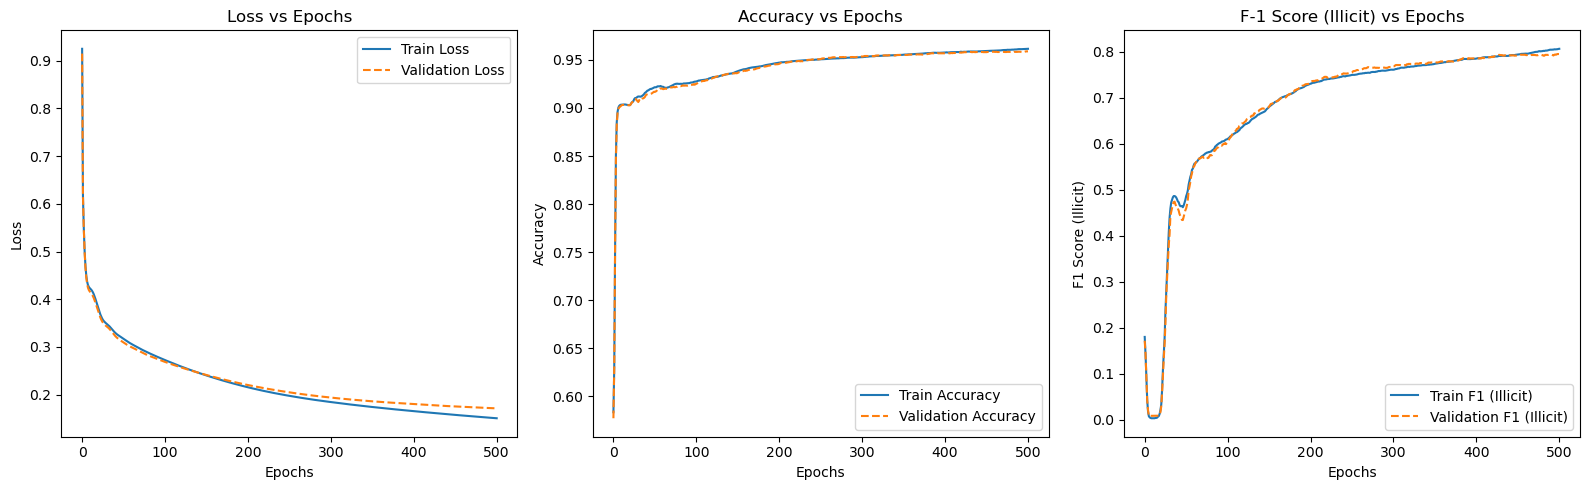

In [7]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(16, 5))

# Plot Losses
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracies
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

# Plot F1
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='Train F1 (Illicit)')
plt.plot(val_f1_scores, label='Validation F1 (Illicit)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Illicit)')
plt.title('F-1 Score (Illicit) vs Epochs')
plt.legend()

plt.savefig('training_gcn_random.png', format='png', dpi=300)

plt.tight_layout()
plt.show() 

In [8]:
# Extract node embeddings
model.eval()
with torch.no_grad():
    embeddings, z = model(data.x, data.edge_index)  # h: embeddings

time_step = torch.tensor(df['time_step'].values, dtype=torch.float)
# Ensure alignment of txId and labels with embeddings
# The order in `data.x` corresponds to `classes['txId']` due to how `all_nodes_dict` was built
aligned_df = pd.DataFrame({
    'txId': classes['txId'],  # Use the original node order
    'time_step': time_step.cpu().numpy(),  # Extract time_step from the GCN input
    'label': classes['label']  # Use the original labels
})

# Add embeddings
embeddings_df = pd.concat([aligned_df, pd.DataFrame(embeddings.cpu().numpy())], axis=1)

# Save to CSV
embeddings_df.to_csv('../data/embeddings_gcn.csv', index=False)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

mask_test = data.y[test_mask] != -1 

predictions = z[test_mask][mask_test].argmax(dim=1).cpu().numpy()
true_labels = data.y[test_mask][mask_test].cpu().numpy()

test_accuracy = accuracy(predictions, true_labels)
precision_ilicit_test = precision_score(true_labels, predictions, pos_label=0)
recall_ilicit_test = recall_score(true_labels, predictions, pos_label=0)
f1_ilicit_test = f1_score(true_labels, predictions, pos_label=0, zero_division=0)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f'Precision node embeddings (gcn): {precision_ilicit_test}')
print(f'Recall node embeddings (gcn): {recall_ilicit_test}')
print(f'F1 node embeddings (gcn): {f1_ilicit_test}')

Test Accuracy: 95.45%
Precision node embeddings (gcn): 0.7732919254658385
Recall node embeddings (gcn): 0.7863157894736842
F1 node embeddings (gcn): 0.7797494780793319


In [10]:
'''embeddings_df.drop(embeddings_df[embeddings_df["label"] == "unknown"].index, inplace=True)
y = embeddings_df['label']
X = embeddings_df.drop(columns=['label'])'''

'embeddings_df.drop(embeddings_df[embeddings_df["label"] == "unknown"].index, inplace=True)\ny = embeddings_df[\'label\']\nX = embeddings_df.drop(columns=[\'label\'])'

In [11]:
'''X_train_gcn = X[X['time_step'].between(1, 34)]
y_train_gcn = y[X['time_step'].between(1, 34)]

X_test_gcn = X[X['time_step'].between(35, 49)]
y_test_gcn = y[X['time_step'].between(35, 49)]'''

"X_train_gcn = X[X['time_step'].between(1, 34)]\ny_train_gcn = y[X['time_step'].between(1, 34)]\n\nX_test_gcn = X[X['time_step'].between(35, 49)]\ny_test_gcn = y[X['time_step'].between(35, 49)]"

In [12]:
'''X_train_gcn = X_train_gcn.drop(columns=['time_step','txId'])
X_test_gcn = X_test_gcn.drop(columns=['time_step','txId'])'''

"X_train_gcn = X_train_gcn.drop(columns=['time_step','txId'])\nX_test_gcn = X_test_gcn.drop(columns=['time_step','txId'])"

In [15]:
embeddings_df = embeddings_df.reset_index(drop=True)

train_indices = torch.nonzero(train_mask, as_tuple=True)[0].cpu().numpy()
val_indices = torch.nonzero(val_mask, as_tuple=True)[0].cpu().numpy()
test_indices = torch.nonzero(test_mask, as_tuple=True)[0].cpu().numpy()

y = embeddings_df['label']
X = embeddings_df.drop(columns=['label'])

X_train_gcn = X.iloc[train_indices]
y_train_gcn = y.iloc[train_indices]

X_val_gcn = X.iloc[val_indices]
y_val_gcn = y.iloc[val_indices]

X_test_gcn = X.iloc[test_indices]
y_test_gcn = y.iloc[test_indices]

X_train_gcn = X_train_gcn[y_train_gcn != "unknown"].drop(columns=['time_step', 'txId'])
y_train_gcn = y_train_gcn[y_train_gcn != "unknown"]

X_val_gcn = X_val_gcn[y_val_gcn != "unknown"].drop(columns=['time_step', 'txId'])
y_val_gcn = y_val_gcn[y_val_gcn != "unknown"]

X_test_gcn = X_test_gcn[y_test_gcn != "unknown"].drop(columns=['time_step', 'txId'])
y_test_gcn = y_test_gcn[y_test_gcn != "unknown"]

X_train_rf = pd.concat([X_train_gcn, X_val_gcn])
y_train_rf = pd.concat([y_train_gcn, y_val_gcn])

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score

clf_gcn = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_gcn.fit(X_train_gcn, y_train_gcn)
y_pred_gcn = clf_gcn.predict(X_test_gcn)

precision_ilicit_gcn = precision_score(y_test_gcn, y_pred_gcn, pos_label='1')
recall_ilicit_gcn = recall_score(y_test_gcn, y_pred_gcn, pos_label='1')
f1_ilicit_gcn = f1_score(y_test_gcn, y_pred_gcn, pos_label='1')
f1_scorer_gcn = make_scorer(f1_score, pos_label='1')
scores_gcn = cross_val_score(clf_gcn, X_train_gcn, y_train_gcn, cv=5, scoring=f1_scorer_gcn)

print(f'Precision node embeddings (gcn): {precision_ilicit_gcn}')
print(f'Recall node embeddings (gcn): {recall_ilicit_gcn}')
print(f'F1 node embeddings (gcn): {f1_ilicit_gcn}')
print("Cross-validated F1 Score node embeddings (gcn):", scores_gcn.mean())

Precision node embeddings (gcn): 0.9420505200594353
Recall node embeddings (gcn): 0.6673684210526316
F1 node embeddings (gcn): 0.7812692544670363
Cross-validated F1 Score node embeddings (gcn): 0.46760242604500324


In [17]:
X_train_gcn.shape

(29803, 128)

In [18]:
# Remove the unknown (-1) labels by masking them out
valid_labels = labels[labels != -1]

# Count the occurrences of each valid label (0 for illicit, 1 for licit)
label_counts = torch.bincount(valid_labels)

# Print the counts for each label
print(f"Illicit (class 0): {label_counts[0].item()}")
print(f"Licit (class 1): {label_counts[1].item()}")

Illicit (class 0): 4545
Licit (class 1): 42019


In [19]:
train_size = (train_mask).sum().item()
val_size = (val_mask).sum().item()
test_size = (test_mask).sum().item()

# Print the sizes of the sets
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Training set size: 130412
Validation set size: 32603
Test set size: 40754


In [20]:
import torch

# Substituir os valores de 'unknown' (-1) por um valor maior para não interferir na contagem das classes 0 e 1
labels_modified = labels.clone()
labels_modified[labels == -1] = 2  # Substitui -1 por 2, por exemplo

# Calcular a frequência das classes para ajustar os pesos
class_counts = torch.bincount(labels_modified)
total_samples = len(labels)
class_weights = total_samples / (len(class_counts) * class_counts.float())

# Definir os pesos para as classes 0 e 1 (ignorando a classe 'unknown' que foi mapeada para 2)
weights = class_weights[:2]  # Apenas as classes 0 e 1


In [21]:
weights

tensor([14.9446,  1.6165])

In [22]:
class_counts

tensor([  4545,  42019, 157205])